In [1]:
import itertools
import math
import gsd.hoomd
import hoomd
import numpy as np
import matplotlib.pyplot as plt
import fresnel
import scipy
import h5py
import time
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import os

if os.path.exists("lattice.gsd"):
    os.remove("lattice.gsd") # clear file if already created
if os.path.exists("random.gsd"):
    os.remove("random.gsd") # clear file if already created

In [3]:
fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"
fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"

In [4]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [5]:
m = 10
N_particles = 2 * m**5 #number of particles (2e5)
Lx = 50.0  
Ly = 50.0 
Lz = 100.0
# manually finding the vertices instead of itertools


In [6]:
# Manually finding the vertices instead of itertools
spacing = (Lx * Ly * Lz / N_particles) ** (1/3)
Kx = math.ceil(Lx / spacing)
Ky = math.ceil(Ly / spacing)
Kz = math.ceil(Lz / spacing)

# Ensure that the dimensions Kx, Ky, and Kz are integers
Kx, Ky, Kz = int(Kx), int(Ky), int(Kz)

# Create arrays for x, y, z with correct dimensions
x = np.linspace(-Lx / 2, Lx / 2, Kx, endpoint=False)
y = np.linspace(-Ly / 2, Ly / 2, Ky, endpoint=False)
z = np.linspace(-Lz / 2, Lz / 2, Kz, endpoint=False)

# Initialize the particle positions array
position = np.zeros((N_particles, 3), dtype=np.float64)

# Create the particle positions using meshgrid
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

# Flatten the positions
position[:, 0] = xx.flatten()[:N_particles]
position[:, 1] = yy.flatten()[:N_particles]
position[:, 2] = zz.flatten()[:N_particles]

In [7]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [Lx, Ly, Lz, 0, 0, 0]
frame.particles.types = ['A']

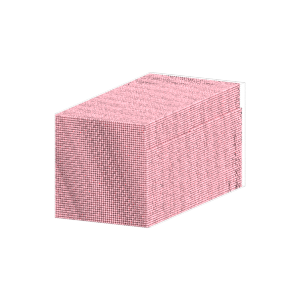

In [8]:
render(frame)

In [9]:
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

In [10]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='lattice.gsd')

In [11]:
integrator = hoomd.md.Integrator(dt=1e-3) 
cell = hoomd.md.nlist.Cell(buffer=0.2) # 0.4 decrease buffer to reduce the number of neighbors
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0 # usually 2.5 but we care about Surface Tension so 5 or larger
integrator.forces.append(lj)

In [12]:
simulation.operations.integrator = integrator

In [13]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(1)

In [14]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists("logStableLiquid.h5"):
    os.remove("logStableLiquid.h5") # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(100), # change how often logger collects here; 
                                  filename='logStableLiquid.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [15]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.1))
integrator.methods.append(nvt)

In [16]:
snapshot = simulation.state.get_snapshot() #Setting random velocities
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [17]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=0.9)

In [18]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.974832129703809

In [19]:
thermodynamic_properties.volume

250000.0

In [20]:
thermodynamic_properties.degrees_of_freedom

599997.0

In [21]:
1 / 2 * 1.5 * thermodynamic_properties.degrees_of_freedom

449997.75

In [22]:
thermodynamic_properties.kinetic_energy

329786.3226952702

In [23]:
thermodynamic_properties.kinetic_temperature

1.099293238783761

In [24]:
simulation.run(500) # was 100000

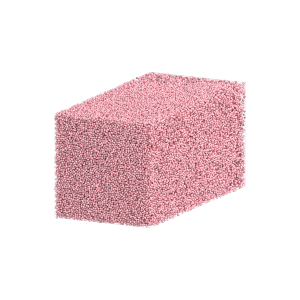

In [25]:
render(simulation.state.get_snapshot())

In [26]:
# simulation.always_compute_pressure = True
# simulation.run(1)
# simulation.always_compute_pressure = False
# thermodynamic_properties.pressure

In [27]:
simulation.run(500)

In [28]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name='logStableLiquid.h5', mode='r')

In [29]:
# import h5py

# def print_hdf5_structure(name, obj):
#     print(name)

# with h5py.File('logStableLiquid.h5', 'r') as hdf5_file:
#     hdf5_file.visititems(print_hdf5_structure)

In [30]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [31]:
print("Pressure Data:", pressure_data)

Pressure Data: [4.64043049 2.25161779 1.82877859 1.79238862 1.78300651 1.73162902
 1.71736085 1.70920233 1.67299978 1.63303391]


In [32]:
print("Temp Data:", temperature_data)

Temp Data: [1.10639175 1.10199167 1.10363377 1.09932443 1.09864287 1.09850496
 1.10216091 1.10169179 1.09938537 1.10260049]


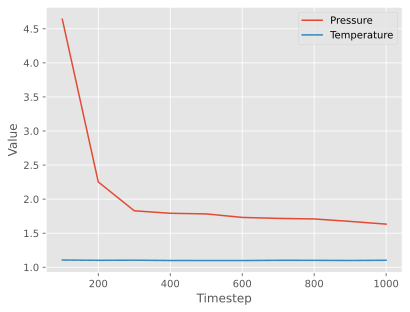

In [33]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

In [34]:
thermodynamic_properties.kinetic_energy

330027.9700670068

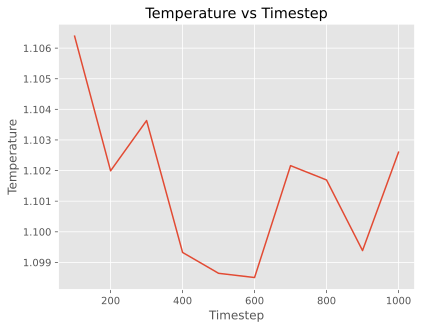

In [35]:
plt.plot(timesteps, temperature_data)
plt.title('Temperature vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.show()

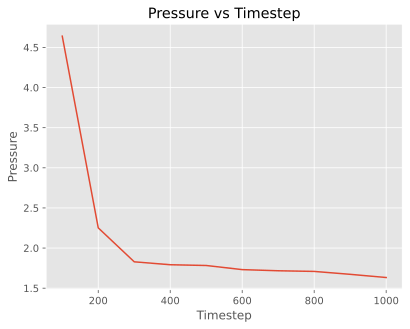

In [36]:
plt.plot(timesteps, pressure_data)
plt.title('Pressure vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Pressure')
plt.show()

In [37]:
hoomd.write.GSD.write(state=simulation.state, filename='random.gsd', mode='xb')